При визуальном сравнении тепловых карт Retention по двум разным источникам мы видим схожий паттерн поведения пользователей в рамках каждой когортной группы: большое количество юзеров в первый день и их значительное снижение в последующие дни.
Также на линейных графиках retention прослеживается недельный паттерн поведения - график напоминает синусоиду, где пиковые значения приходятся преимущественно на воскресенья, а падения - на четверг. То есть большинство новых пользователей приходит в конце недели. 

Для определения есть ли статистически значимые различия между retention двух групп произведены расчеты ниже

In [81]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import scipy.stats

In [1]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231020',
'user':'student',
'password':'_'
}

In [83]:
query_ads = '''
SELECT start_date, date, retention_rate, 1 - retention_rate as churn_rate
from
(SELECT toDate(cnt_users_by_days.start_date) as start_date, toDate(cnt_users_by_days.date) as date, round(cnt_users_by_days.users / total_users.total_per_start_day, 3) as retention_rate
FROM
  (SELECT toString(start_date) as start_date, toString(date) as date, count(distinct user_id) as users  
  FROM 
    (SELECT user_id , min(toDate(time)) as start_date
    from simulator_20231020.feed_actions 
    WHERE source = 'ads'
    GROUP By user_id
    HAVING start_date >= today() - 30) t1   
  JOIN 
    (SELECT DISTINCT user_id, toDate(time) as date
    FROM simulator_20231020.feed_actions 
    WHERE source = 'ads'
    ) t2     
  USING user_id 
  GROUP BY start_date, date
  ORDER BY start_date DESC) as cnt_users_by_days
LEFT JOIN
  (SELECT toString(start_date) as start_date, count(distinct user_id) as total_per_start_day  
  FROM 
    (SELECT user_id , min(toDate(time)) as start_date
    from simulator_20231020.feed_actions 
    WHERE source = 'ads'
    GROUP By user_id
    HAVING start_date >= today() - 30) t1   
  JOIN        
    (SELECT DISTINCT user_id, toDate(time) as date
    FROM simulator_20231020.feed_actions 
    WHERE source = 'ads'
    ) t2
  USING user_id      
  GROUP BY start_date
  ORDER BY start_date DESC) as total_users
ON cnt_users_by_days.start_date = total_users.start_date)
'''

df_ads = ph.read_clickhouse(query_ads, connection=connection)

In [84]:
df_ads.head()

,start_date,date,retention_rate,churn_rate
0,2023-11-01,2023-11-01,1.000,0.000
1,2023-10-31,2023-10-31,1.000,0.000
2,2023-10-31,2023-11-01,0.347,0.653
3,2023-10-30,2023-10-31,0.403,0.597
4,2023-10-30,2023-10-30,1.000,0.000


Посмотрим на распределение в двух выборках

<Axes: xlabel='retention_rate', ylabel='Count'>

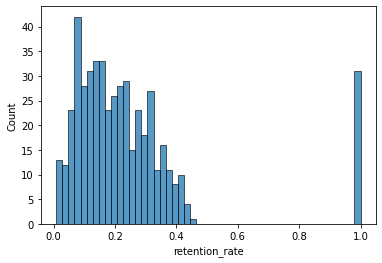

In [85]:
sns.histplot(df_ads.retention_rate, bins=50)

In [86]:
query_org = '''
SELECT start_date, date, retention_rate, 1 - retention_rate as churn_rate
from
(SELECT toDate(cnt_users_by_days.start_date) as start_date, toDate(cnt_users_by_days.date) as date, round(cnt_users_by_days.users / total_users.total_per_start_day, 3) as retention_rate
FROM
  (SELECT toString(start_date) as start_date, toString(date) as date, count(distinct user_id) as users  
  FROM 
    (SELECT user_id , min(toDate(time)) as start_date
    from simulator_20231020.feed_actions 
    WHERE source = 'organic'
    GROUP By user_id
    HAVING start_date >= today() - 30) t1   
  JOIN 
    (SELECT DISTINCT user_id, toDate(time) as date
    FROM simulator_20231020.feed_actions 
    WHERE source = 'organic'
    ) t2     
  USING user_id 
  GROUP BY start_date, date
  ORDER BY start_date DESC) as cnt_users_by_days
LEFT JOIN
  (SELECT toString(start_date) as start_date, count(distinct user_id) as total_per_start_day  
  FROM 
    (SELECT user_id , min(toDate(time)) as start_date
    from simulator_20231020.feed_actions 
    WHERE source = 'organic'
    GROUP By user_id
    HAVING start_date >= today() - 30) t1   
  JOIN        
    (SELECT DISTINCT user_id, toDate(time) as date
    FROM simulator_20231020.feed_actions 
    WHERE source = 'organic'
    ) t2
  USING user_id      
  GROUP BY start_date
  ORDER BY start_date DESC) as total_users
ON cnt_users_by_days.start_date = total_users.start_date)
'''

df_organic = ph.read_clickhouse(query_org, connection=connection)

In [87]:
df_organic.head()

,start_date,date,retention_rate,churn_rate
0,2023-11-01,2023-11-01,1.000,0.000
1,2023-10-31,2023-10-31,1.000,0.000
2,2023-10-31,2023-11-01,0.394,0.606
3,2023-10-30,2023-10-31,0.474,0.526
4,2023-10-30,2023-10-30,1.000,0.000


<Axes: xlabel='retention_rate', ylabel='Count'>

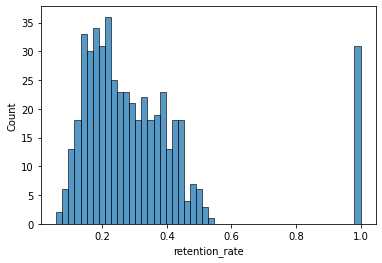

In [88]:
sns.histplot(df_organic.retention_rate, bins=50)

Так как выборки имеют не нормальное распределение для сравнения будем применять U-критерий Манна-Уитни.
Определим, есть ли статистически значимые различия между показателями Retention_rate в двух выборках. 

Нулевая гипотеза H0: вероятность, что случайный (x_organic > y_ads) = вероятности, что случайный (x_ads > y_organic)

In [89]:
scipy.stats.mannwhitneyu(df_ads['retention_rate'], df_organic['retention_rate'])

MannwhitneyuResult(statistic=83752.0, pvalue=3.2773389152339823e-18)

p-value < 0.05. Таким образом, можем сделать вывод о том, что данные выборки имеют статистически значимые различия

Также посмотрим есть ли разница между показателями Churn_rate 

<Axes: xlabel='date'>

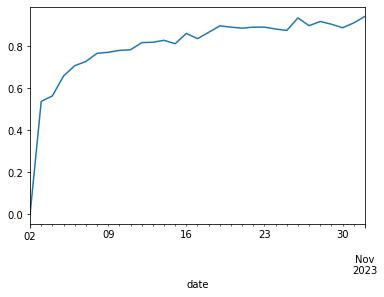

In [90]:
df_organic.groupby('date').churn_rate.max().plot(kind='line')

<Axes: xlabel='date'>

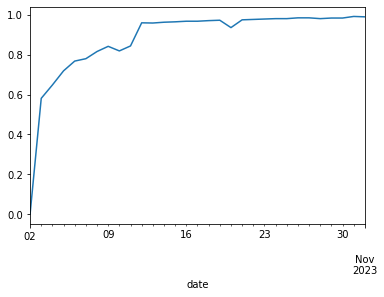

In [91]:
df_ads.groupby('date').churn_rate.max().plot(kind='line')

In [92]:
scipy.stats.mannwhitneyu(df_ads['churn_rate'], df_organic['churn_rate'])

MannwhitneyuResult(statistic=162264.0, pvalue=3.2773389152339823e-18)

p-value < 0.05, т.е. выборки имеют статистически значимые различия, отклоняем H0.

По графикам показателя churn_rate мы видим, что больше половины пользователей "отваливается" уже на второй день: 54% в группе organic против 58% в группе ads. То есть пользователи первой группы чуть более лояльны к нашей ленте новостей. Но несмотря на то, что разница между показателями второго дня составляет 4% (а в последующие дни еще меньше), с помощью критерия Манна-Уитни мы убедились, что данные различия являются статистически значимыми и характер использования приложения у данных групп пользователей не одинаковый. 

Однако если еще посмотреть на обе метрики (retention и churn) с практической точки зрения, показатели и второго дня, и всех последующих являются очень высокими, то есть пользователи очень быстро теряют интерес к нашей ленте по каким-то причинам. Для выявления этих причин требуется провести дополнительных анализ.